# Classifying Dog Breeds on Images
<img src="misc/dog_breeds.jpg" alt="Dog Breeds" align='left' style="width: 30%; height: 30%"/> <br clear='left'>
### Why:
Have a look at this article: https://www.theinsurancealliance.com/10-dog-breeds-your-insurance-company-doesnt-like/<br>
Some insurance companies don't want to insure certain dog breeds because they are known to be riskier than others.<br>
A possible solution to this problem is to ask the dog owner to provide details about the dog breed - but how can you make sure that these details were right?

An idea could be to have the dog owner provide images of the dog. But now the question comes up: Who will look at these images and determine the breed?<br>
While you could hire an expert for dog breeds and have him classify all the images, it may not be the most efficient process.<br>
Instead you could try to develop a computer vision model that is able to detect the breed automatically and also provides a probability how likely its predictions is.<br>

The experts can focus on images where the model's probability was low - saving them time by not having to look at all images.<br>
After they've classified the difficult images with their expert knowledge, you can use these new labeled data to further improve your model.

This way you can save a lot of manual effort and speed up the approval process - making dog owners happy. :)

### Data:
This data was taken from Kaggle and is a subset of the ImageNet dataset. Link: https://www.kaggle.com/c/dog-breed-identification <br>
It originally contains 120 different dog breeds but it was downsampled to only 16 classes to save training time.

# Imports

We start by importing various SAS and Open Source packages:<br>
* SWAT = [SAS Scripting Wrapper for Analytics Transfer (SWAT)](https://github.com/sassoftware/python-swat)
* DLPY = [SAS Viya Deep Learning API for Python](https://github.com/sassoftware/python-dlpy)



In [1]:
# SAS
from swat import CAS
from dlpy.utils import *
from dlpy.applications import *
from dlpy.model import *
from dlpy.images import *
from dlpy.lr_scheduler import *
from dlpy.splitting import two_way_split
from dlpy.metrics import accuracy_score, confusion_matrix, f1_score
# Open Source
import os
import seaborn as sn

In [2]:
# Set working directory
working_directory = os.getcwd()
working_directory

'/data/notebooks/github.com/SAS_DeepLearning/Dog Breed Identification'

# Connection to our SAS environment

In [3]:
s = CAS(hostname='localhost', port=5570, username='username', password='password')

# Load and view our image data

In [4]:
image_data = ImageTable.load_files(conn=s, 
                                   path='{}/train_sas_16cl'.format(working_directory), 
                                   casout=dict(name='image_data'))

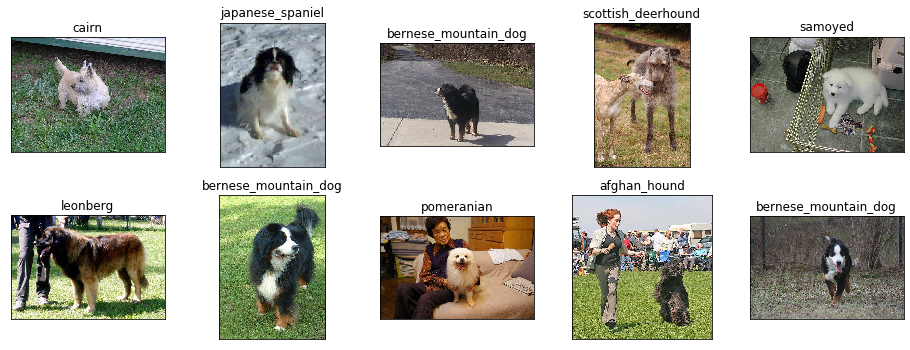

In [5]:
image_data.show(nimages=10, ncol=5, randomize=True)

Lets see how many images per breed we have. This also gives you a sign whether you have skewed data and should consider up- or downsampling.<br>
In our case we have a very well balanced dataset.

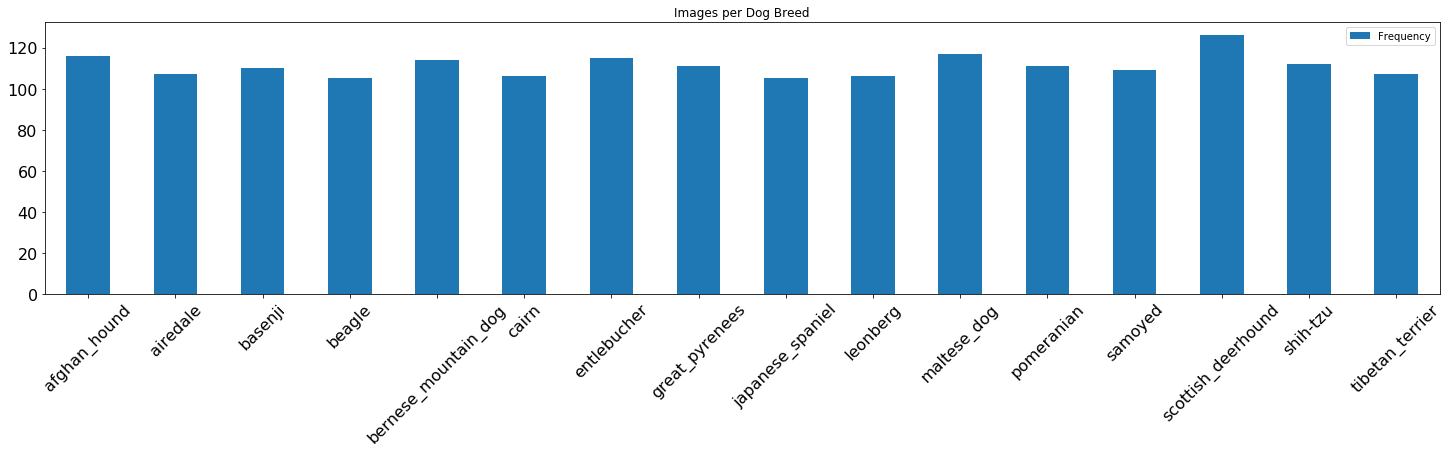

In [6]:
image_data.label_freq.plot.bar(y='Frequency', figsize=(25,5), rot=45, fontsize=16, title='Images per Dog Breed')

We should also have a look at the image summary.<br>
As you can see we varying image sizes (minWidth, maxWidth, minHeight, maxHeight). <br>
Computer Vision models usually prefer images of the same size, therefore we will perform a resizing.<br>
You should also have a look at the channels - in this case we have 3 because we are dealing with colored images. But it could also be a single channel if you deal with black/white images.

Additionally we shuffle our training data and split it into a training and a validation part.

In [7]:
image_data.image_summary

jpg                  1777
minWidth              117
maxWidth             2048
minHeight             103
maxHeight            1536
meanWidth         452.724
meanHeight        393.384
mean1stChannel     99.404
min1stChannel           0
max1stChannel         255
mean2ndChannel    114.371
min2ndChannel           0
max2ndChannel         255
mean3rdChannel    119.467
min3rdChannel           0
max3rdChannel         255
dtype: object

In [8]:
image_data.resize(width=224, height=224, inplace=True)

In [10]:
image_data.shuffle(casout=dict(name='image_data', replace=True))

[caslib]

 'CASUSER(sas)'

[tableName]

 'IMAGE_DATA'

[casTable]

 CASTable('IMAGE_DATA', caslib='CASUSER(sas)')

+ Elapsed: 0.0665s, user: 0.0533s, sys: 0.0719s, mem: 79.4mb

In [11]:
trainData, validData = two_way_split(image_data, test_rate=20, seed=12345)

Lets have a last look at our training and validation data.<br>
As you can see, we have 1424 training images and 353 validation images.<br>
The bar plots show hat we still have a very well balanced datasets after splitting the data.

In [12]:
len(trainData), len(validData)

(1424, 353)

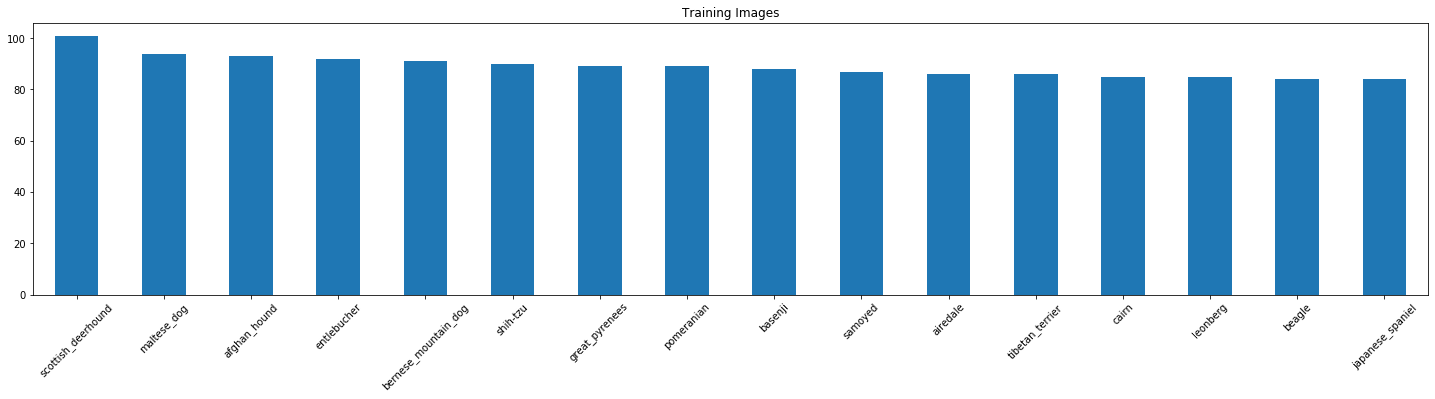

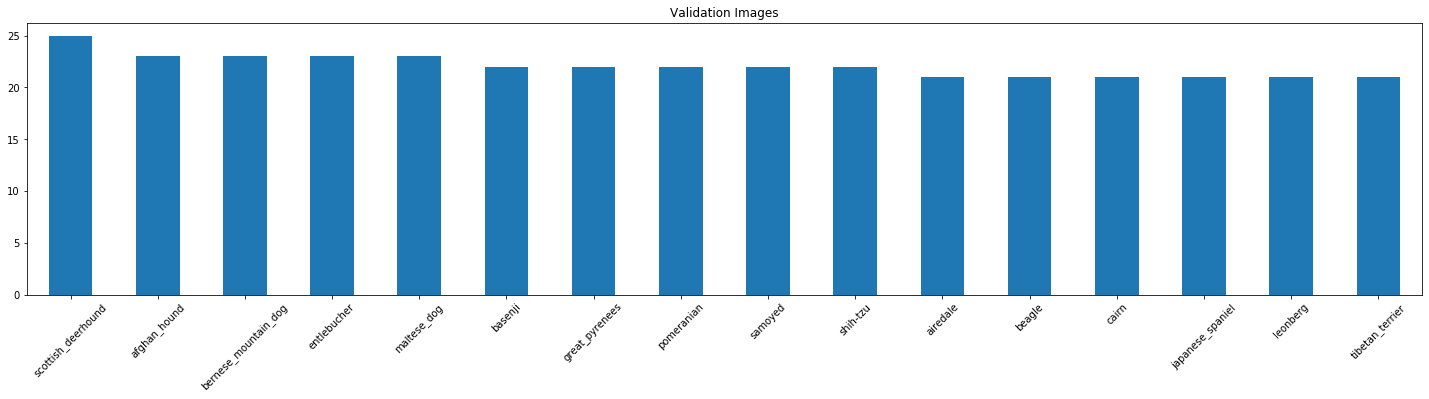

In [16]:
fig, ax = plt.subplots()
trainData['_label_'].value_counts().plot(ax=ax, kind='bar', rot=45, title='Training Images', figsize=(25,5))
fig, ax = plt.subplots()
validData['_label_'].value_counts().plot(ax=ax, kind='bar', rot=45, title='Validation Images', figsize=(25,5))

# Build your Computer Vision Model
We make use of a publicly available pretrained model that will be adjusted to fit our needs.<br>
This model was trained on ImageNet and can classifiy images into 1000 different categories.<br>
We will remove the very last layer and replace it with a fully connected layer outputting our 16 different Dog Breeds.<br>
The model should be downloaded here: https://s3.amazonaws.com/onnx-model-zoo/resnet/resnet50v1/resnet50v1.onnx

In [17]:
import onnx
onnx_model = onnx.load_model('/data/notebooks/github.com/models/ONNX/resnet50/resnet50v1.onnx')

In [18]:
model = Model.from_onnx_model(s, 
                               onnx_model,
                               output_model_table='resnet50v1',
                               scale=1./255., 
                               offsets=[0.485, 0.456, 0.406])

NOTE: Successfully written weights file as /data/notebooks/github.com/SAS_DeepLearning/Dog Breed Identification/resnet50v1_weights.onnxmodel.h5
NOTE: Model table is attached successfully!
NOTE: Model is named to "resnet50v1" according to the model name in the table.
NOTE: Successfully imported ONNX model.


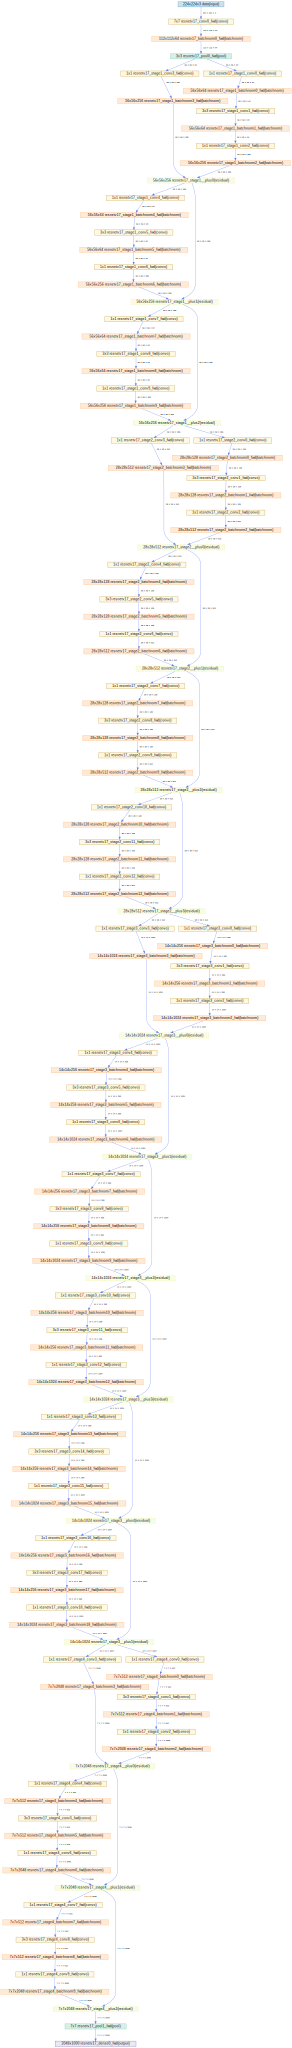

In [19]:
model.plot_network()

In [65]:
# Display first 5 layers of ResNet model
model.summary.head(5)

,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters,FLOPS(forward pass)
0,None,data,input,,,None,"(224, 224, 3)","(0, 0)",0
1,None,resnetv17_conv0_fwd,convo,"(7, 7)","(2.0, 2.0)",Identity,"(112, 112, 64)","(9408, 0)",118013952
2,None,resnetv17_batchnorm0_fwd,batchnorm,,,Rectifier,"(112, 112, 64)","(0, 128)",0
3,None,resnetv17_pool0_fwd,pool,"(3, 3)","(2.0, 2.0)",Max,"(56, 56, 64)","(0, 0)",0
4,None,resnetv17_stage1_conv3_fwd,convo,"(1, 1)","(1.0, 1.0)",Identity,"(56, 56, 256)","(16384, 0)",51380224


Looking at the first input layer we can see that our model expects inputs to be of size (224, 224, 3).<br>
224 pixels height, 224 pixel width and 3 color channels (Red, Green, Blue).<br>
Rember when we looked at the image_summary and decided to resize the images? :)

In [25]:
# Display last 10 layers of ResNet model
model.summary.tail(10)

,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters,FLOPS(forward pass)
116,None,resnetv17_stage4__plus1,residual,,,Rectifier,"(7, 7, 2048)","(0, 0)",0
117,None,resnetv17_stage4_conv7_fwd,convo,"(1, 1)","(1.0, 1.0)",Identity,"(7, 7, 512)","(1048576, 512)",51380224
118,None,resnetv17_stage4_batchnorm7_fwd,batchnorm,,,Rectifier,"(7, 7, 512)","(0, 1024)",0
119,None,resnetv17_stage4_conv8_fwd,convo,"(3, 3)","(1.0, 1.0)",Identity,"(7, 7, 512)","(2359296, 0)",115605504
120,None,resnetv17_stage4_batchnorm8_fwd,batchnorm,,,Rectifier,"(7, 7, 512)","(0, 1024)",0
121,None,resnetv17_stage4_conv9_fwd,convo,"(1, 1)","(1.0, 1.0)",Identity,"(7, 7, 2048)","(1048576, 2048)",51380224
122,None,resnetv17_stage4_batchnorm9_fwd,batchnorm,,,Identity,"(7, 7, 2048)","(0, 4096)",0
123,None,resnetv17_stage4__plus2,residual,,,Rectifier,"(7, 7, 2048)","(0, 0)",0
124,None,resnetv17_pool1_fwd,pool,"(7, 7)","(7.0, 7.0)",Mean,"(1, 1, 2048)","(0, 0)",0
125,None,output,output,"(2048, 16)",,Softmax,16,"(32768, 16)",0


As said, we will have to remove the last layer (resnetv17_dense0_fwd) that predicts 1000 classes and create a new one with just 16 classes.<br>
We also drop the corresponding weights because we want to learn new ones.

In [21]:
model_table = s.CASTable(model.model_table['name'])
model.load_weights(path='/data/notebooks/github.com/SAS_DeepLearning/Dog Breed Identification/resnet50v1_weights.onnxmodel.h5') # This weight file was created while loading the ONNX model
s.removelayer(modeltable=model_table, 
              name='resnetv17_dense0_fwd') # removes last layer
s.addlayer(modeltable=model_table, 
           name='output', 
           layer=(dict(type='output', 
                       n=len(trainData.label_freq), # Create new last layer with number of labels in Trainingdata
                       act='softmax')), 
           srcLayers=['resnetv17_pool1_fwd'])
model.model_weights = model.model_weights[model.model_weights['_LayerID_'] < 125] # Only select weights from layers below layer-id 125 (remove weights of last layer from weight-table)
model = Model.from_table(model_table)

NOTE: no dataspec(s) provided - creating image classification model.
NOTE: Model weights attached successfully!
NOTE: Model table is attached successfully!
NOTE: Model is named to "resnet50v1" according to the model name in the table.


As you can see, the last layer now only outputs our 16 different classes.

In [22]:
model.summary.tail(10)

,Layer Id,Layer,Type,Kernel Size,Stride,Activation,Output Size,Number of Parameters,FLOPS(forward pass)
116,None,resnetv17_stage4__plus1,residual,,,Rectifier,"(7, 7, 2048)","(0, 0)",0
117,None,resnetv17_stage4_conv7_fwd,convo,"(1, 1)","(1.0, 1.0)",Identity,"(7, 7, 512)","(1048576, 512)",51380224
118,None,resnetv17_stage4_batchnorm7_fwd,batchnorm,,,Rectifier,"(7, 7, 512)","(0, 1024)",0
119,None,resnetv17_stage4_conv8_fwd,convo,"(3, 3)","(1.0, 1.0)",Identity,"(7, 7, 512)","(2359296, 0)",115605504
120,None,resnetv17_stage4_batchnorm8_fwd,batchnorm,,,Rectifier,"(7, 7, 512)","(0, 1024)",0
121,None,resnetv17_stage4_conv9_fwd,convo,"(1, 1)","(1.0, 1.0)",Identity,"(7, 7, 2048)","(1048576, 2048)",51380224
122,None,resnetv17_stage4_batchnorm9_fwd,batchnorm,,,Identity,"(7, 7, 2048)","(0, 4096)",0
123,None,resnetv17_stage4__plus2,residual,,,Rectifier,"(7, 7, 2048)","(0, 0)",0
124,None,resnetv17_pool1_fwd,pool,"(7, 7)","(7.0, 7.0)",Mean,"(1, 1, 2048)","(0, 0)",0
125,None,output,output,"(2048, 16)",,Softmax,16,"(32768, 16)",0


We can see that the last layer now outputs 16 classes. The model is ready to be trained.

## Defining the training process
We will use a Momentumsolver with a starting learning rate of 0.1.<br>
During the training process we will use a learning rate scheduler that shrinks the learning rate size depending on how well the learning process performs.<br>

Also note that we will make use of GPU acceleration which significantly improves training speed.<br>
If you encounter errors its most likely that your GPU runs out of memory. In this case you can try to lower the batch size.<br>

If you want to know more about what solvers, optimizers and learning rate schedulers are available, have a look at:
https://sassoftware.github.io/python-dlpy/api.html

In [26]:
lr_scheduler = ReduceLROnPlateau(conn=s, 
                                 cool_down_iters=10, 
                                 gamma=0.1, 
                                 learning_rate=0.1, 
                                 patience=15)
solver = MomentumSolver(momentum=0.9, 
                        lr_scheduler=lr_scheduler, 
                        clip_grad_max=100, 
                        clip_grad_min=-100)
optimizer = Optimizer(algorithm=solver, 
                      mini_batch_size=256, 
                      log_level=2, 
                      max_epochs=100, 
                      reg_l2=0.0005,
                      stagnation=10,
                      bn_src_layer_warnings=False)
gpu = Gpu(devices=[0])

The following argument(s) learning_rate, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.


Last but not least we will define the input and output data for our model.<br>
If you stick to the standard data loading processes that will create two columns '_image_' and '_label_' you can skip this step.
However I still recommend to do it to make sure you're using the right data.

In [27]:
dataspecs=[dict(type='image', layer='data', data=['_image_']),
           dict(type='numnom', layer='output', data=['_label_'])]

In [28]:
model.fit(data=trainData,
          valid_table=validData,
          optimizer=optimizer,
          data_specs=dataspecs,
          n_threads=1, 
          record_seed=54321,
          force_equal_padding=True, 
          gpu=gpu,
          save_best_weights=True)

NOTE: Training based on existing weights.
NOTE: Using michael-AERO-15-X9: 1 out of 1 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 23559696.
NOTE:  The approximate memory cost is 527.00 MB.
NOTE:  Loading weights cost       0.51 (s).
NOTE:  Initializing each layer cost       3.84 (s).
NOTE:  The total number of threads on each worker is 1.
NOTE:  The total mini-batch size per thread on each worker is 256.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 256.
NOTE:  Target variable: _label_
NOTE:  Number of levels for the target variable:     16
NOTE:  Levels for the target variable:
NOTE:  Level      0: afghan_hound        
NOTE:  Level      1: airedale            
NOTE:  Level      2: basenji             
NOTE:  Level      3: beagle              
NOTE:  Level      4: bernese_mountain_dog
NOTE:  Level      5: cairn               
NOTE:  Level      6: entlebucher         
NOTE:  Level      7: great_py

,Descr,Value
0,Model Name,resnet50v1
1,Model Type,Convolutional Neural Network
2,Number of Layers,126
3,Number of Input Layers,1
4,Number of Output Layers,1
5,Number of Convolutional Layers,53
6,Number of Pooling Layers,2
7,Number of Fully Connected Layers,0
8,Number of Batch Normalization Layers,53
9,Number of Residual Layers,16


# Lets see how our training progressed over time
As you can see, we've reached reasonable results at epochs 70 and later. You could improve this if you include more data, use more complex models and spend more time on training<br>
The best model weights were save and can be referenced by model.best_weights

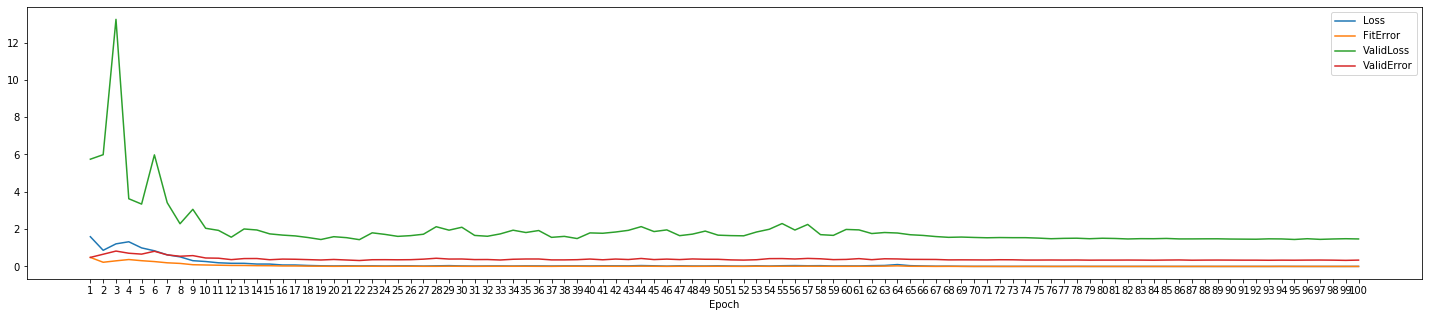

In [37]:
model.plot_training_history(items=['Loss','FitError','ValidLoss','ValidError'], fig_size=(25, 5))

We can also see that our learning rate dropped at epoch 62, leading to a more consistent validation loss.

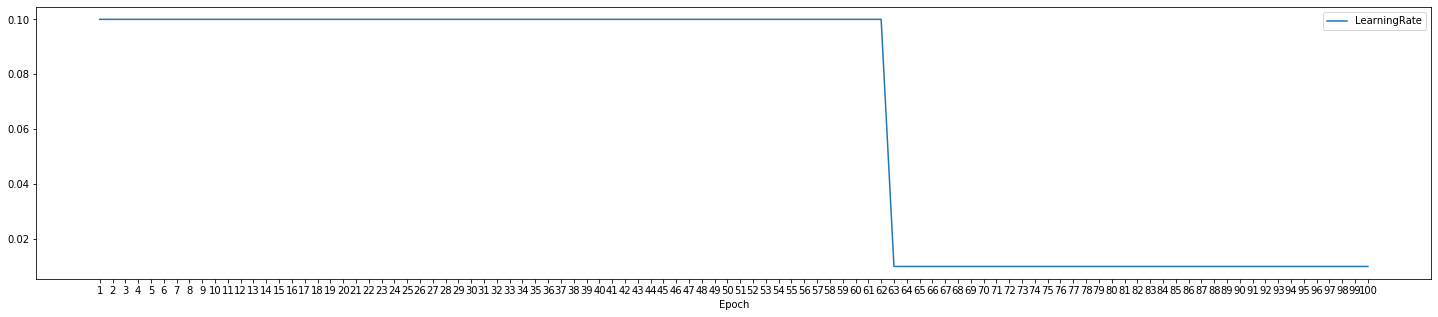

In [38]:
model.plot_training_history(items=['LearningRate'], fig_size=(25, 5))

Setting the models weights to the best weights we've learned during our training process.<br>
Afterwards evaluate our model performance on our validation data.

In [39]:
model.set_weights(model.best_weights)

NOTE: Model weights attached successfully!


In [40]:
model.evaluate(data=validData, gpu=gpu)

NOTE: Using michael-AERO-15-X9: 1 out of 1 available GPU devices.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read           353
 1  Number of Observations Used           353
 2  Misclassification Error (%)      31.72805
 3                   Loss Error      1.435602

[OutputCasTables]

          casLib              Name  Rows  Columns  \
 0  CASUSER(sas)  Valid_Res_Z0mJhV   353       23   
 
                                             casTable  
 0  CASTable('Valid_Res_Z0mJhV', caslib='CASUSER(s...  

+ Elapsed: 4.71s, user: 3.95s, sys: 0.459s, mem: 380mb

We have builtin support for scikit-learn evaluation metrics.<br>
Lets calculate Accuary and F1 measure:

In [41]:
model_accuracy = accuracy_score(model.valid_res_tbl['_label_'], model.valid_res_tbl['I__label_'])*100
model_f1 = f1_score(model.valid_res_tbl['_label_'], model.valid_res_tbl['I__label_'], pos_label=1)
print('Accuracy: {} %'.format(model_accuracy))
print('F1 Score: {}'.format(model_f1))

Accuracy: 68.27195467422096 %
F1 Score: 0.8


Lets plot a confusion matrix heatmap using seaborn package to visually explore our model performance.<br>
Values on the diagonal axis are correct predictions, all others are misclassifications.<br>
We can see that the majority of classes have a decent accuracy.

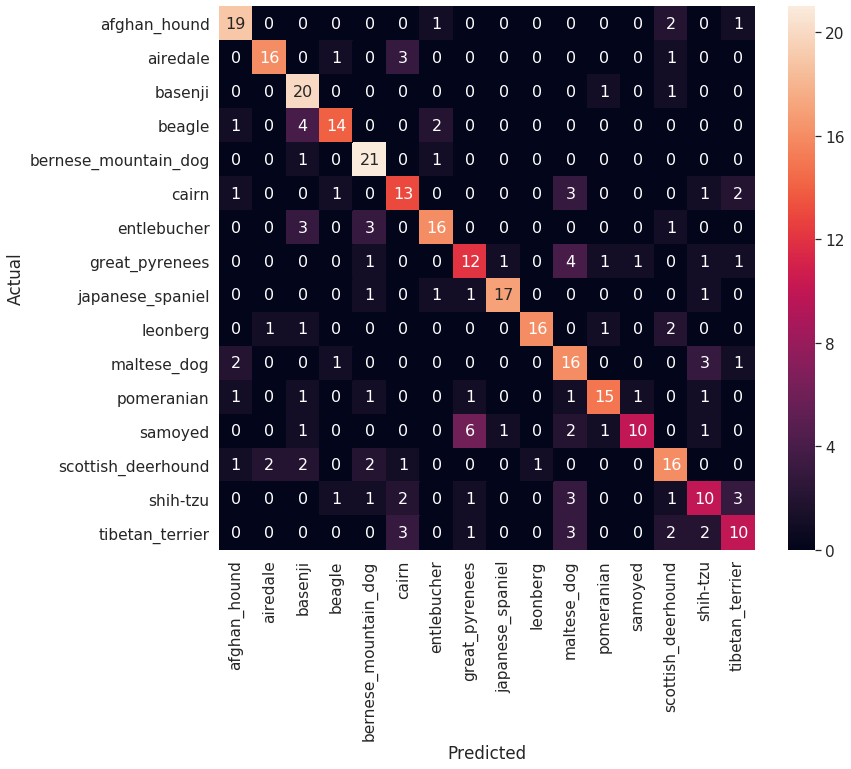

In [42]:
cfm_all = confusion_matrix(model.valid_res_tbl['_label_'], model.valid_res_tbl['I__label_'])
cfm_all.index.name = 'Actual'
cfm_all.columns.name = 'Predicted'
plt.figure(figsize = (12,10))
sn.set(font_scale=1.4)
sn.heatmap(cfm_all, annot=True, annot_kws={'size':16})

Lets have a look at the created prediction dataset.<br>
We can see that we have probabilities for each class (P__label_[class]) as well as a final predicted class (I__label_) with its corresponding probability (_DL_PredP_).

In [43]:
model.valid_res_tbl.head(10)

,_image_,_label_,_filename_0,_id_,P__label_afghan_hound,P__label_airedale,P__label_basenji,P__label_beagle,P__label_bernese_mountain_dog,P__label_cairn,...,P__label_leonberg,P__label_maltese_dog,P__label_pomeranian,P__label_samoyed,P__label_scottish_deerhound,P__label_shih_tzu,P__label_tibetan_terrier,I__label_,_DL_PredP_,_DL_PredLevel_
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,bernese_mountain_dog,1e99c23d5ce88bc408cb8c1111d86796.jpg,1236,4.315342e-05,4.207957e-07,1.108289e-07,7.298411e-08,9.993678e-01,1.308763e-07,...,2.295995e-08,1.877714e-08,5.679372e-08,5.957050e-07,9.381411e-08,5.881797e-08,5.577895e-04,bernese_mountain_dog,0.999368,4.0
1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,tibetan_terrier,c5cb2d2a9038b1181c7820ef05e838db.jpg,519,4.368774e-02,3.250771e-03,1.532968e-06,3.989449e-05,6.400096e-06,2.658201e-04,...,1.442212e-04,1.683545e-04,2.027085e-05,1.136813e-04,1.013127e-03,3.945208e-03,9.462142e-01,tibetan_terrier,0.946214,15.0
2,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,entlebucher,e3f184140f68b3502dfb048607556438.jpg,728,4.887460e-10,5.118212e-10,2.175482e-10,1.170370e-10,1.017001e-05,1.000000e-10,...,1.437402e-09,1.000000e-10,1.000000e-10,2.997121e-10,1.000000e-10,1.000000e-10,2.923646e-09,entlebucher,0.999990,6.0
3,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,maltese_dog,3c3e2f645fa36df8bd4d2b4b5168cdf1.jpg,1066,1.174934e-02,1.464630e-03,2.136862e-04,1.967682e-03,9.576518e-04,2.739690e-03,...,3.619877e-05,8.336430e-01,4.338318e-04,1.197147e-02,4.027969e-04,2.851086e-03,5.612423e-02,maltese_dog,0.833643,10.0
4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,afghan_hound,9cde15dd34bbf752d6ac654295938a1e.jpg,1214,9.999659e-01,2.216961e-06,1.809115e-06,1.371536e-08,3.099954e-06,4.517476e-07,...,1.847843e-06,9.280300e-08,8.677561e-08,5.551385e-06,7.028877e-06,4.763408e-08,6.937176e-06,afghan_hound,0.999966,0.0
5,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,shih-tzu,566adbe64cf98307231658cb834cffb7.jpg,1570,1.438401e-05,7.737855e-06,5.626300e-07,1.529748e-03,1.548260e-04,1.943099e-05,...,3.946054e-07,5.087961e-03,2.411975e-05,3.040326e-06,1.255770e-05,9.730367e-01,1.445532e-02,shih-tzu,0.973037,14.0
6,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,samoyed,11c0aaa58a419a61513b5c1f27b67f16.jpg,956,1.000000e-10,1.000000e-10,1.409979e-08,1.000000e-10,1.691206e-08,9.620420e-09,...,1.000000e-10,9.659253e-09,8.019980e-01,1.980010e-01,8.465406e-10,1.000000e-10,1.622450e-10,pomeranian,0.801998,11.0
7,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,beagle,bdec813dff4bb79ff07cbe0440f217a2.jpg,116,9.979658e-01,3.383437e-04,1.554751e-04,2.769460e-06,5.662391e-04,8.985498e-05,...,1.513273e-04,1.146836e-06,4.942303e-06,1.932989e-05,2.830582e-04,9.494772e-07,2.022457e-04,afghan_hound,0.997966,0.0
8,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,tibetan_terrier,89e653251ebdb4125224d3af5230587e.jpg,459,2.378706e-05,2.523523e-04,6.590710e-07,1.095396e-03,2.048281e-04,1.090081e-04,...,1.511107e-06,4.114243e-03,1.154324e-05,4.205609e-06,4.947404e-04,1.428132e-01,8.507622e-01,tibetan_terrier,0.850762,15.0
9,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,entlebucher,b8dcf30dd6d0b661fbdc892c8047e179.jpg,676,6.879377e-06,4.159037e-06,8.607353e-06,3.296811e-06,7.982606e-02,3.085743e-06,...,1.419635e-05,7.595054e-07,1.401733e-06,2.843962e-06,6.891029e-07,3.566165e-06,9.228929e-05,entlebucher,0.919974,6.0


Lets look at some correctly and incorrectly classified pictures!<br>
An important aspect is to verify what your model is actually looking at. <br>
E.g. it could be that images of a particular dog breed were mostly taken inside while images of another breed are taken outside. A model could learn to distinguish them not by looking at the dog but at the environment.

NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(sas).
NOTE: Table FILTERED_RMLY12 contains compressed images.
NOTE: Cloud Analytic Services dropped table FILTERED_RMLY12 from caslib CASUSER(sas).


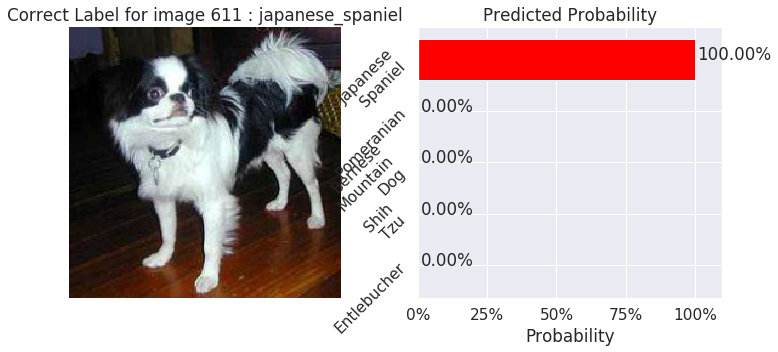

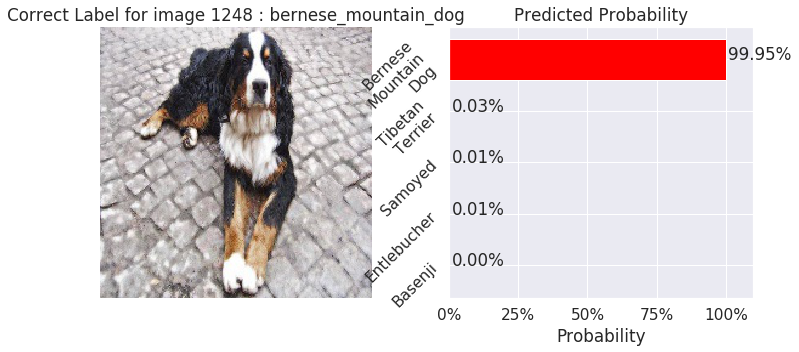

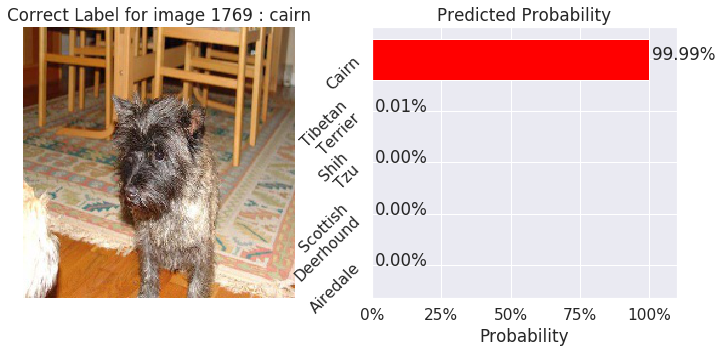

In [59]:
# Good examples
model.plot_evaluate_res(img_type='C', image_id=[1769, 611, 1248])

Using results from model.predict()
 filtering by filename or _id_ 
NOTE: Cloud Analytic Services dropped table TEMP_ANOTATED from caslib CASUSER(sas).
NOTE: Table FILTERED_6HYKAF contains compressed images.


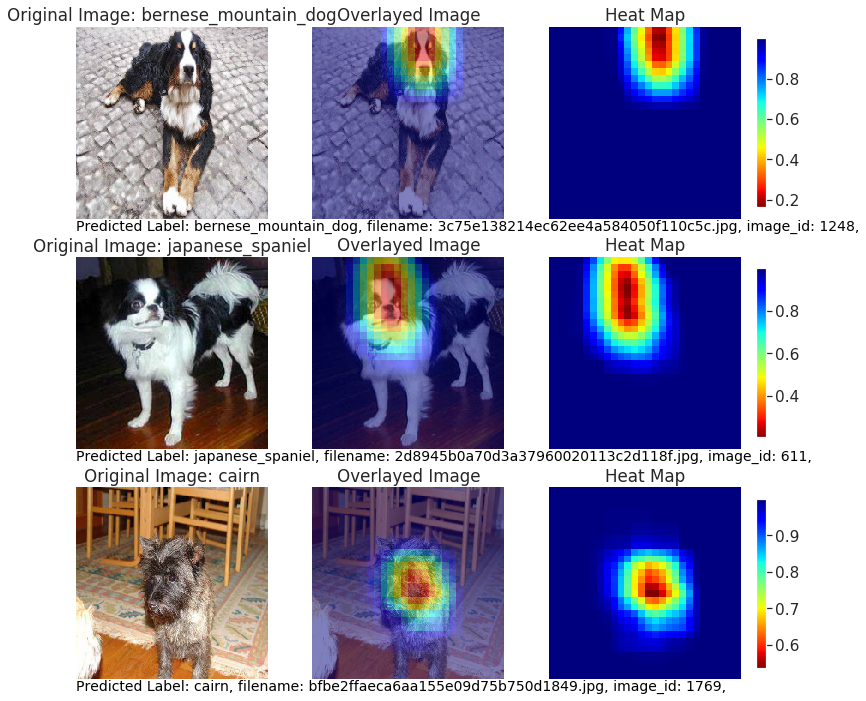

NOTE: Cloud Analytic Services dropped table FILTERED_6HYKAF from caslib CASUSER(sas).


,_id_,_filename_0,_image_,_label_,I__label_,heat_map,P__label_afghan_hound,P__label_airedale,P__label_basenji,P__label_beagle,...,P__label_entlebucher,P__label_great_pyrenees,P__label_japanese_spaniel,P__label_leonberg,P__label_maltese_dog,P__label_pomeranian,P__label_samoyed,P__label_scottish_deerhound,P__label_shih_tzu,P__label_tibetan_terrier
0,1248,3c75e138214ec62ee4a584050f110c5c.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,bernese_mountain_dog,bernese_mountain_dog,"[[0.9994158744812012, 0.9994158744812012, 0.99...",7.878965e-07,5.746615e-06,8.175251e-06,6.369215e-07,...,7.710436e-05,7.059811e-08,1.858509e-06,3.560841e-08,1.132072e-08,4.079571e-07,1.061680e-04,1.899027e-07,5.462885e-08,2.608034e-04
1,611,2d8945b0a70d3a37960020113c2d118f.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,japanese_spaniel,japanese_spaniel,"[[0.9999904632568359, 0.9999904632568359, 0.99...",2.750644e-09,1.000000e-10,3.613991e-09,1.406984e-07,...,5.548018e-07,2.442250e-08,9.999911e-01,1.051313e-10,5.694029e-08,5.023166e-06,4.866195e-08,9.725960e-10,9.554388e-07,7.488860e-09
2,1769,bfbe2ffaeca6aa155e09d75b750d1849.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,cairn,cairn,"[[0.9999616146087646, 0.9999616146087646, 0.99...",1.516069e-07,7.136458e-06,1.455756e-07,1.644624e-08,...,8.754910e-10,5.820599e-08,8.297479e-09,3.068951e-06,4.045449e-07,1.394230e-06,2.660119e-07,1.147202e-05,1.504134e-05,6.061314e-05


In [60]:
# Heatmaps for good examples
model.heat_map_analysis(mask_width=56, mask_height=56, step_size=8, image_id=[1769, 611, 1248])

We can see that the model is really looking at the dogs to do its classification.<br>
But how about other examples that were classified wrong?

NOTE: Cloud Analytic Services dropped table TEMP_PLOT from caslib CASUSER(sas).
NOTE: Table FILTERED_HIYLDN contains compressed images.
NOTE: Cloud Analytic Services dropped table FILTERED_HIYLDN from caslib CASUSER(sas).


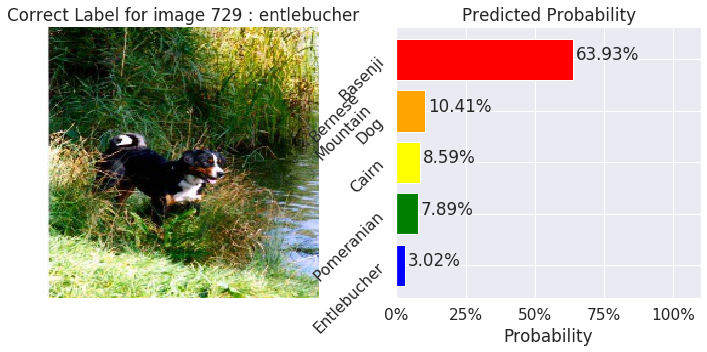

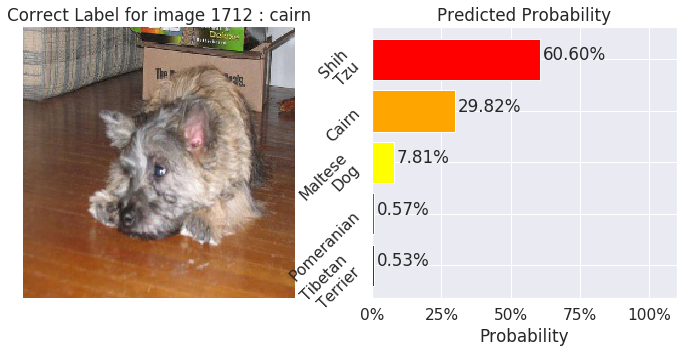

In [73]:
# bad examples
model.plot_evaluate_res(img_type='M', image_id=[1712,729])

Using results from model.predict()
 filtering by filename or _id_ 
NOTE: Cloud Analytic Services dropped table TEMP_ANOTATED from caslib CASUSER(sas).
NOTE: Table FILTERED_HRPKFF contains compressed images.


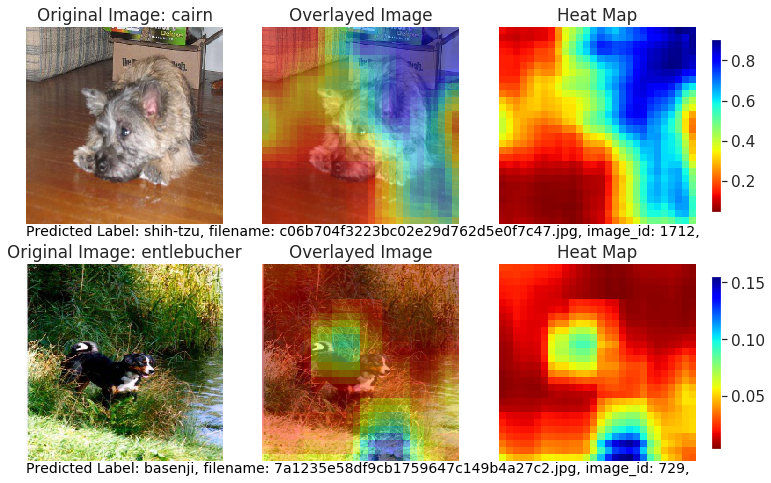

NOTE: Cloud Analytic Services dropped table FILTERED_HRPKFF from caslib CASUSER(sas).


,_id_,_filename_0,_image_,_label_,I__label_,heat_map,P__label_afghan_hound,P__label_airedale,P__label_basenji,P__label_beagle,...,P__label_entlebucher,P__label_great_pyrenees,P__label_japanese_spaniel,P__label_leonberg,P__label_maltese_dog,P__label_pomeranian,P__label_samoyed,P__label_scottish_deerhound,P__label_shih_tzu,P__label_tibetan_terrier
0,1712,c06b704f3223bc02e29d762d5e0f7c47.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,cairn,shih-tzu,"[[0.13036489486694336, 0.13036489486694336, 0....",0.000356,0.000812,0.000463,0.000577,...,0.000013,0.000544,0.000400,0.000046,0.078146,0.005656,0.000418,0.002702,0.606037,0.005296
1,729,7a1235e58df9cb1759647c149b4a27c2.jpg,<PIL.JpegImagePlugin.JpegImageFile image mode=...,entlebucher,basenji,"[[0.027412734925746918, 0.027412734925746918, ...",0.005321,0.010639,0.639269,0.007310,...,0.030238,0.001491,0.001726,0.027758,0.000640,0.078927,0.001800,0.003285,0.001436,0.000122


In [71]:
# Heatmaps for bad examples
model.heat_map_analysis(mask_width=56, mask_height=56, step_size=8, image_id=[1712,729])

We can see that in these cases the model mostly focussed on the background, leading to wrong predictions.<br>
As said, this can be improved with more data, more complex models, more training time, hyper parameter tuning, etc.

# Deployment
Finally we want to deploy our models. There are various options available but a very common one is to create a single SAS astore file that can be used in scoring applications.<br>
You could also export your model as a CAS Table or ONNX-file that allows further training.<br>
Note: Due to Github file size restrictions I only share models that are below 100MB.

In [64]:
model.deploy(path=working_directory, output_format='astore')

NOTE: Model astore file saved successfully.


In [ ]:
model.deploy(path=working_directory, output_format='castable')

In [ ]:
model.deploy(path='/data/notebooks/deep_learning_examples/Dog Breed Identification/trained_models/16cl_100ep/', output_format='onnx')